In [21]:
from typing import Tuple, List

import pandas as pd
import numpy as np
import random
import knn as kn
import helper as h
import matplotlib.pyplot as plt
import fscore as f
from tqdm import tqdm

In [2]:
filename = 'ecoli.csv'
loaded_dataset = pd.read_csv(filename)

In [3]:
loaded_dataset

,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,0
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,0
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,0
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,0
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,0
...,...,...,...,...,...,...,...,...
322,0.74,0.56,0.48,0.5,0.47,0.68,0.30,7
323,0.71,0.57,0.48,0.5,0.48,0.35,0.32,7
324,0.61,0.60,0.48,0.5,0.44,0.39,0.38,7
325,0.59,0.61,0.48,0.5,0.42,0.42,0.37,7


In [4]:
def minmax(dataset):
    result: List[Tuple[float, float]] = []
    for i in range(len(dataset[0]) - 1):
        result.append((dataset[:, i].min(), dataset[:, i].max()))
    return result


def normalize(dataset):
    new_dataset = dataset.copy()
    min_max = minmax(dataset)
    for row in new_dataset:
        for i in range(len(row) - 1):
            if min_max[i][1] - min_max[i][0] == 0:
                row[i] = row[i]
            else:
                row[i] = (row[i] - min_max[i][0]) / (min_max[i][1] - min_max[i][0])
    return new_dataset


def classes_number(dataset: List[Tuple[List[float], int]]):
    classes = set()
    for row in dataset:
        classes.add(row[1])
    print(classes)
    return len(classes)

def shift_classes_if_needed(dataset):
    new_dataset = dataset.copy()
    cl = 0
    new_classes = {}
    for row in new_dataset:  
        if row[len(row) - 1] not in new_classes:
            new_classes[row[len(row) - 1]] = cl 
            cl = cl + 1
        row[len(row) - 1] = new_classes[row[len(row) - 1]]
    return new_dataset
        


In [5]:
normalized_dataset = normalize(loaded_dataset.values)
cool_dataset = shift_classes_if_needed(normalized_dataset)


In [6]:
pd.DataFrame(cool_dataset)

,0,1,2,3,4,5,6,7
0,0.550562,0.154762,0.0,0.5,0.636364,0.216495,0.353535,0.0
1,0.078652,0.285714,0.0,0.5,0.613636,0.329897,0.444444,0.0
2,0.629213,0.285714,0.0,0.5,0.556818,0.350515,0.464646,0.0
3,0.662921,0.392857,0.0,0.5,0.590909,0.432990,0.363636,0.0
4,0.258427,0.190476,0.0,0.5,0.625000,0.226804,0.353535,0.0
...,...,...,...,...,...,...,...,...
322,0.831461,0.476190,0.0,0.5,0.534091,0.670103,0.303030,4.0
323,0.797753,0.488095,0.0,0.5,0.545455,0.329897,0.323232,4.0
324,0.685393,0.523810,0.0,0.5,0.500000,0.371134,0.383838,4.0
325,0.662921,0.535714,0.0,0.5,0.477273,0.402062,0.373737,4.0


In [7]:
max_dist = 0
for row1 in cool_dataset:
    for row2 in cool_dataset:
        max_dist = max(h.calculate_distance(row1[: len(row1) - 1],row2[:len(row2) - 1], h.Distance.euclidean), max_dist)
max_dist

1.5005041867655102

In [8]:
def all_models():
    models = []
    for window in h.all_windows():
        for kernel in h.all_kernels():
            for distance in h.all_distances():
                params = []
                if window == h.Window.variable:
                    params = range(1, 50, 8)
                else:
                    params = np.linspace(0.1, 1.5, 10)
                for param in params:
                    model = h.Model(distance, kernel, window, param)
                    models.append(model)
    return models

In [9]:
models = all_models()

In [11]:
def build_cm_naive(dataset: List[Tuple[List[float], int]], model: h.Model):
    n = classes_number(dataset)
    cm = [[0 for _ in range(n)] for _i in range(n)]
    for target_i in range(len(dataset)):
        obj, label = dataset[target_i]
        train_set = dataset[:target_i]
        if target_i != len(dataset) - 1:
            train_set += dataset[target_i + 1:]
        prediction = h.predict_class_of_target_naive(train_set, obj, model)
        cm[int(label)][prediction] += 1
    return cm

def build_cm_onehot(dataset: List[Tuple[List[float], int]], model: h.Model):
    n = classes_number(dataset)
    cm = [[0 for _ in range(n)] for _i in range(n)]
    for target_i in range(len(dataset)):
        obj, label = dataset[target_i]
        train_set = dataset[:target_i]
        if target_i != len(dataset) - 1:
            train_set += dataset[target_i + 1:]
        prediction = h.predict_class_of_target_onehot(train_set, obj, model, n)
        cm[int(label)][prediction] += 1
    return cm

def dataset_to_local_representation(dataset):
    values = dataset.tolist()
    my_dataset = []
    for row in values:
        attrs_row = []
        for i in (range(len(row) - 1)):
            attrs_row.append(row[i])
        label = row[len(row) - 1]
        my_dataset.append((attrs_row, label))
    return my_dataset

def classes_number(dataset: List[Tuple[List[float], int]]):
    classes = set()
    for row in dataset:
        classes.add(row[1])
    return len(classes)

In [12]:
local_dataset = dataset_to_local_representation(cool_dataset)
max_macro_f1 = 0
max_micro_f1 = 0
best_model_by_macro_f1 = models[0]
best_model_by_micro_f1 = models[0]
for model in tqdm(models):
    cm = build_cm_naive(local_dataset, model)
    macro_f1, micro_f1 = f.macro_micro_f(cm)
    if macro_f1 > max_macro_f1:
        best_model_by_macro_f1 = model
        max_macro_f1 = macro_f1
    if micro_f1 > max_micro_f1:
        best_model_by_micro_f1 = model
        max_micro_f1 = micro_f1
        

print(max_macro_f1)
print(best_model_by_macro_f1)
print(max_micro_f1)
print(best_model_by_micro_f1)

100%|██████████| 510/510 [51:54<00:00,  6.11s/it]    

0.8434845400410951
Model: Distance.euclidean Kernel.tricube Window.fixed 0.25555555555555554
0.8398511922250027
Model: Distance.euclidean Kernel.tricube Window.fixed 0.25555555555555554


In [16]:
cm = build_cm_naive(local_dataset, best_model_by_micro_f1)
pd.DataFrame(cm)

,0,1,2,3,4
0,128,13,1,0,1
1,2,59,16,0,0
2,1,13,21,0,0
3,0,0,1,18,1
4,2,3,5,16,26


In [17]:
cm = build_cm_naive(local_dataset, best_model_by_macro_f1)
pd.DataFrame(cm)

,0,1,2,3,4
0,128,13,1,0,1
1,2,59,16,0,0
2,1,13,21,0,0
3,0,0,1,18,1
4,2,3,5,16,26


In [18]:
best_model_by_macro_f1 = models[0]
best_model_by_micro_f1 = models[0]
max_macro_f1 = 0
max_micro_f1 = 0
local_dataset = dataset_to_local_representation(cool_dataset)
for model in tqdm(models):
    cm = build_cm_onehot(local_dataset, model)
    macro_f1, micro_f1 = f.macro_micro_f(cm)
    if macro_f1 > max_macro_f1:
        best_model_by_macro_f1 = model
        max_macro_f1 = macro_f1
    if micro_f1 > max_micro_f1:
        best_model_by_micro_f1 = model
        max_micro_f1 = micro_f1
        

print(max_macro_f1)
print(best_model_by_macro_f1)
print(max_micro_f1)
print(best_model_by_micro_f1)

100%|██████████| 510/510 [12:09<00:00,  1.43s/it]

0.880598391051597
Model: Distance.euclidean Kernel.gaussian Window.fixed 0.1
0.8792923030790766
Model: Distance.euclidean Kernel.gaussian Window.fixed 0.1


In [19]:
cm = build_cm_naive(local_dataset, best_model_by_macro_f1)
pd.DataFrame(cm)

,0,1,2,3,4
0,132,8,1,1,1
1,3,60,14,0,0
2,1,11,23,0,0
3,0,0,1,18,1
4,3,2,0,14,33


In [26]:
params_fixed = np.linspace(0.01, 1.5, 100)
f_macro_scores = []
f_micro_scores = []
for param in tqdm(params_fixed):
    best_model = h.Model(h.Distance.euclidean, h.Kernel.tricube, h.Window.fixed, param)
    cm = build_cm_onehot(local_dataset, best_model)
    macro_f1, micro_f1 = f.macro_micro_f(cm)
    f_macro_scores.append(macro_f1)
    f_micro_scores.append(micro_f1)


100%|██████████| 100/100 [02:03<00:00,  1.23s/it]


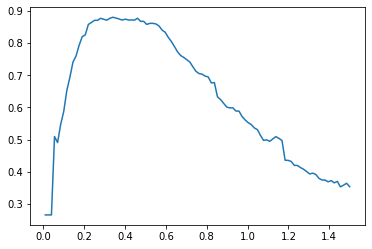

In [27]:
plt.plot(params_fixed, f_macro_scores)

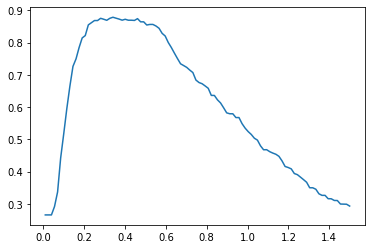

In [28]:
plt.plot(params_fixed, f_micro_scores)